In [4]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [5]:
import os, glob

# CHANGE THIS if your folder is somewhere else
DATA_DIR = "/content/drive/MyDrive/Data"

print("Listing files in:", DATA_DIR)
print("\n".join(os.listdir(DATA_DIR)))


Listing files in: /content/drive/MyDrive/Data
schizophrenia_post_features_tfidf_256.csv
bpd_post_features_tfidf_256.csv
autism_post_features_tfidf_256.csv
socialanxiety_post_features_tfidf_256.csv
suicidewatch_post_features_tfidf_256.csv
alcoholism_post_features_tfidf_256.csv
addiction_post_features_tfidf_256.csv
ptsd_post_features_tfidf_256.csv
bipolarreddit_post_features_tfidf_256.csv
anxiety_post_features_tfidf_256.csv
suicidewatch_post_features_tfidf_256.xlsx
addiction_post_features_tfidf_256.xlsx


## Load all 10 CSVs into one DataFrame

In [15]:
import pandas as pd
import glob
import os
import numpy as np
import seaborn as sns

pattern = os.path.join(DATA_DIR, "*_post_features_tfidf_256.csv")
files = glob.glob(pattern)

if not files:
    raise FileNotFoundError("No *_post_features_tfidf_256.csv found in the folder!")

dfs = []

for path in files:
    df = pd.read_csv(path)
    base = os.path.basename(path)
    subreddit = base.split("_post_features")[0]   # e.g., "addiction"
    df["subreddit"] = subreddit
    dfs.append(df)
    print(f"Loaded {base:45s} rows={len(df)}")

full_df = pd.concat(dfs, ignore_index=True)
print("\nTOTAL ROWS:", len(full_df))
print("\nSubreddit distribution:\n", full_df["subreddit"].value_counts())


Loaded schizophrenia_post_features_tfidf_256.csv     rows=1863
Loaded bpd_post_features_tfidf_256.csv               rows=5973
Loaded autism_post_features_tfidf_256.csv            rows=2209
Loaded socialanxiety_post_features_tfidf_256.csv     rows=3738
Loaded suicidewatch_post_features_tfidf_256.csv      rows=21410
Loaded alcoholism_post_features_tfidf_256.csv        rows=1428
Loaded addiction_post_features_tfidf_256.csv         rows=1783
Loaded ptsd_post_features_tfidf_256.csv              rows=2059
Loaded bipolarreddit_post_features_tfidf_256.csv     rows=1368
Loaded anxiety_post_features_tfidf_256.csv           rows=15896

TOTAL ROWS: 57727

Subreddit distribution:
 subreddit
suicidewatch     21410
anxiety          15896
bpd               5973
socialanxiety     3738
autism            2209
ptsd              2059
schizophrenia     1863
addiction         1783
alcoholism        1428
bipolarreddit     1368
Name: count, dtype: int64


In [7]:
# Data Cleaning
full_df = pd.concat(dfs, ignore_index=True)
print("\nTOTAL ROWS:", len(full_df))
print("\nSubreddit distribution:\n", full_df["subreddit"].value_counts())



TOTAL ROWS: 57727

Subreddit distribution:
 subreddit
suicidewatch     21410
anxiety          15896
bpd               5973
socialanxiety     3738
autism            2209
ptsd              2059
schizophrenia     1863
addiction         1783
alcoholism        1428
bipolarreddit     1368
Name: count, dtype: int64



DataFrame info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57727 entries, 0 to 57726
Columns: 350 entries, subreddit to tfidf_year
dtypes: float64(270), int64(76), object(4)
memory usage: 154.1+ MB
None

Missing values per column:
subreddit                      0
author                         0
date                           0
post                           0
automated_readability_index    0
                              ..
tfidf_wors                     0
tfidf_would                    0
tfidf_wrong                    0
tfidf_x200b                    0
tfidf_year                     0
Length: 350, dtype: int64


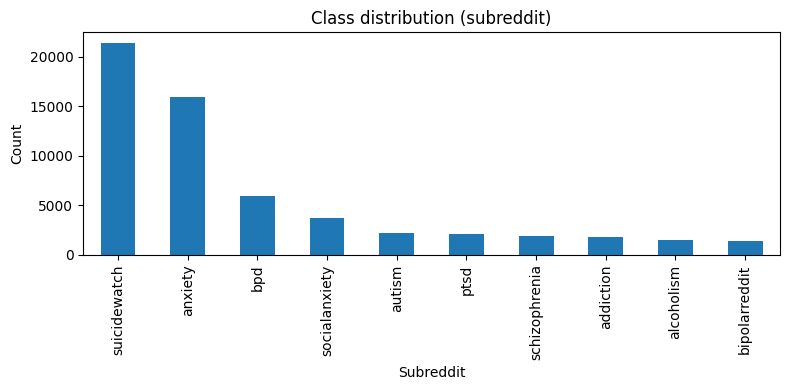


Numeric feature summary (first few columns):
       automated_readability_index  coleman_liau_index  \
count                 57727.000000        57727.000000   
mean                      3.301852            4.774445   
std                       3.560545            3.587942   
min                      -8.832500          -16.400473   
25%                       1.345034            3.217013   
50%                       2.984553            4.604882   
75%                       4.825742            6.035196   
max                     215.628000          271.098320   

       flesch_kincaid_grade_level  flesch_reading_ease  gulpease_index  \
count                57727.000000         57727.000000    57727.000000   
mean                     4.444132            84.815982       76.996342   
std                      2.303011            11.856231       11.896001   
min                     -3.010000          -508.880000     -349.000000   
25%                      3.006081            79.469122       

In [8]:
# Extra imports for EDA, feature selection, CV, ROC/AUC, and plots
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import label_binarize

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    auc)

# EDA: data types & missing values

print("\nDataFrame info():")
print(full_df.info())

print("\nMissing values per column:")
print(full_df.isna().sum())

# If there are any missing numeric values, fill them with 0 (common for TF-IDF)
numeric_cols_all = full_df.select_dtypes(include=[np.number]).columns
full_df[numeric_cols_all] = full_df[numeric_cols_all].fillna(0)

# Distribution of the target classes (bar plot) – shows imbalance
plt.figure(figsize=(8,4))
full_df["subreddit"].value_counts().plot(kind="bar")
plt.title("Class distribution (subreddit)")
plt.xlabel("Subreddit")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Quick look at basic statistics for numeric features
print("\nNumeric feature summary (first few columns):")
print(full_df[numeric_cols_all].describe().iloc[:, :10])


## Prepare features X and labels y

In [9]:
label_col = "subreddit"

# all non-label columns
feature_cols = [c for c in full_df.columns if c != label_col]

# numeric columns only (TF-IDF + readability features, etc.)
numeric_cols = full_df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

# Feature engineering
full_df["tfidf_sum"] = full_df[numeric_cols].sum(axis=1)
full_df["tfidf_sum_bin"] = pd.qcut(full_df["tfidf_sum"], q=4, labels=False)

numeric_cols = numeric_cols + ["tfidf_sum_bin"]


# Remove constant (zero-variance) features

vt = VarianceThreshold(threshold=0.0)
X_numeric = full_df[numeric_cols].values
X_reduced = vt.fit_transform(X_numeric)

# Keep only columns with non-zero variance
kept_mask = vt.variances_ > 0.0
numeric_cols = [col for col, keep in zip(numeric_cols, kept_mask) if keep]

print("Number of numeric feature columns after removing constants:", len(numeric_cols))

X = X_reduced
y = full_df[label_col].values


/tmp/ipython-input-3031121494.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_df["tfidf_sum"] = full_df[numeric_cols].sum(axis=1)
/tmp/ipython-input-3031121494.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_df["tfidf_sum_bin"] = pd.qcut(full_df["tfidf_sum"], q=4, labels=False)


Number of numeric feature columns after removing constants: 347


## Split into train, validation, and test

In [10]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_STATE = 42

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=(TEST_SIZE + VAL_SIZE),
    random_state=RANDOM_STATE,
    stratify=y
)

relative_test = TEST_SIZE / (TEST_SIZE + VAL_SIZE)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=relative_test,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

print("Train size:", X_train.shape[0])
print("Val size:  ", X_val.shape[0])
print("Test size: ", X_test.shape[0])


Train size: 40408
Val size:   8659
Test size:  8660


## Train the Multinomial Logistic Regression model

In [11]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    multi_class="multinomial",
    solver="saga",
    max_iter=1000,
    n_jobs=-1,
    class_weight="balanced"
)

print("Training model...")
clf.fit(X_train, y_train)
print("Training complete.")


Training model...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training complete.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Evaluate the model

In [12]:
from sklearn.metrics import classification_report, accuracy_score

y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_test)

print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (TEST):")
print(classification_report(y_test, y_test_pred))


Validation accuracy: 0.3305231550987412
Test accuracy: 0.3420323325635104

Classification Report (TEST):
               precision    recall  f1-score   support

    addiction       0.09      0.09      0.09       267
   alcoholism       0.20      0.62      0.31       214
      anxiety       0.56      0.11      0.19      2385
       autism       0.13      0.42      0.20       332
bipolarreddit       0.07      0.30      0.12       205
          bpd       0.24      0.20      0.22       896
         ptsd       0.11      0.22      0.15       309
schizophrenia       0.13      0.26      0.17       279
socialanxiety       0.20      0.18      0.19       561
 suicidewatch       0.65      0.60      0.62      3212

     accuracy                           0.34      8660
    macro avg       0.24      0.30      0.23      8660
 weighted avg       0.46      0.34      0.35      8660




=== Tuning Logistic Regression with GridSearchCV ===
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best params: {'C': 10.0}


<Figure size 600x600 with 0 Axes>

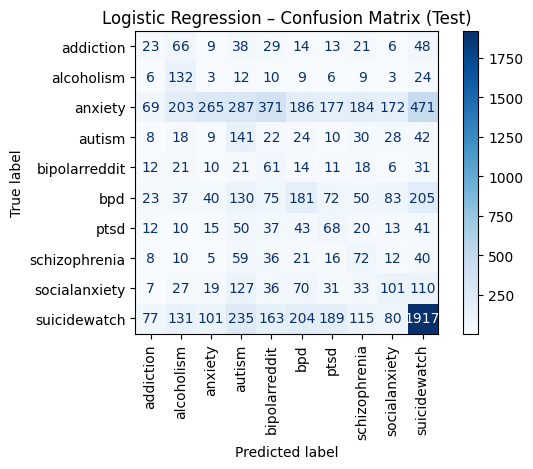


Logistic Regression macro AUC – train: 0.743, val: 0.733, test: 0.737


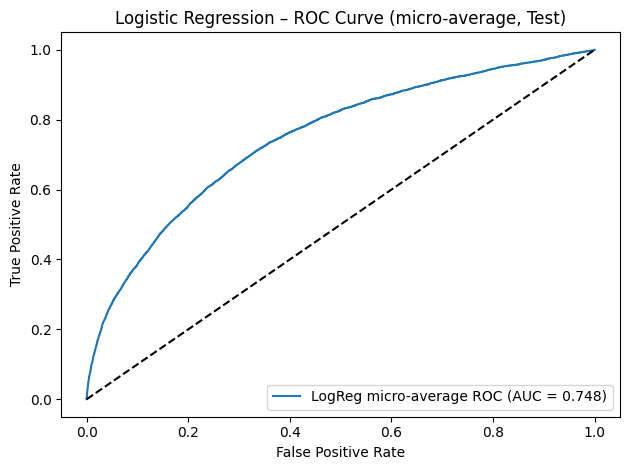

In [13]:

# Part A (Logistic Regression) – CV + Hyperparameter Tuning + ROC/AUC

# Base model for tuning
log_reg_base = LogisticRegression(
    multi_class="multinomial",
    solver="saga",
    max_iter=1000,
    n_jobs=-1,
    class_weight="balanced"
)

param_grid = {
    "C": [0.1, 1.0, 3.0, 10.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_reg_grid = GridSearchCV(
    estimator=log_reg_base,
    param_grid=param_grid,
    scoring="roc_auc_ovr_weighted",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

print("\n=== Tuning Logistic Regression with GridSearchCV ===")
log_reg_grid.fit(X_train, y_train)
print("Best params:", log_reg_grid.best_params_)

best_log_reg = log_reg_grid.best_estimator_

# Confusion matrix on TEST
plt.figure(figsize=(6,6))
ConfusionMatrixDisplay.from_estimator(
    best_log_reg,
    X_test,
    y_test,
    xticks_rotation=90,
    cmap="Blues"
)
plt.title("Logistic Regression – Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

# ROC/AUC (macro) for train/val/test
classes_lr = best_log_reg.classes_

def multiclass_auc(model, X, y):
    y_bin = label_binarize(y, classes=classes_lr)
    y_score = model.predict_proba(X)
    return roc_auc_score(y_bin, y_score, average="macro", multi_class="ovr")

log_train_auc = multiclass_auc(best_log_reg, X_train, y_train)
log_val_auc   = multiclass_auc(best_log_reg, X_val, y_val)
log_test_auc  = multiclass_auc(best_log_reg, X_test, y_test)

print(f"\nLogistic Regression macro AUC – train: {log_train_auc:.3f}, "
      f"val: {log_val_auc:.3f}, test: {log_test_auc:.3f}")

# Example: multi-class ROC curve (macro-average)
y_test_bin = label_binarize(y_test, classes=classes_lr)
y_test_score = best_log_reg.predict_proba(X_test)

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure()
plt.plot(fpr_micro, tpr_micro, label=f"LogReg micro-average ROC (AUC = {roc_auc_micro:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression – ROC Curve (micro-average, Test)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [ ]:
# Macro averages
precision = 0.46
recall = 0.34
f1_score = 0.35

# Construct a 2x2 “performance” matrix
# Rows: Actual / Columns: Predicted (simplified interpretation)
heatmap_data = pd.DataFrame(
    [[precision, 1 - precision],
     [1 - recall, recall]],
    index=['Actual Positive', 'Actual Negative'],
    columns=['Predicted Positive', 'Predicted Negative']
)

plt.figure(figsize=(6,5))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')
plt.title('Macro-Averaged Performance Heatmap')
plt.show()

## Train Linear SVM (with probabilities)

In [14]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Base linear SVM (no probabilities by itself)
base_svm = LinearSVC(
    class_weight="balanced",   # handle class imbalance
    random_state=42
)

# Wrap with calibration to get predict_proba
clf = CalibratedClassifierCV(
    base_svm,
    method="sigmoid",   # Platt scaling
    cv=3                # 3-fold for calibration
)

print("Training Linear SVM (with probability calibration)...")
clf.fit(X_train, y_train)
print("Training complete.")


Training Linear SVM (with probability calibration)...
Training complete.


## Evaluate the SVM model

In [15]:
from sklearn.metrics import classification_report, accuracy_score

y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_test)

print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))

print("\nClassification Report (TEST):")
print(classification_report(y_test, y_test_pred))


Validation accuracy: 0.7451206836817185
Test accuracy: 0.7390300230946882

Classification Report (TEST):
               precision    recall  f1-score   support

    addiction       0.79      0.55      0.65       267
   alcoholism       0.74      0.63      0.68       214
      anxiety       0.75      0.81      0.78      2385
       autism       0.51      0.45      0.48       332
bipolarreddit       0.47      0.17      0.25       205
          bpd       0.74      0.56      0.64       896
         ptsd       0.77      0.49      0.60       309
schizophrenia       0.49      0.30      0.37       279
socialanxiety       0.60      0.44      0.51       561
 suicidewatch       0.78      0.94      0.85      3212

     accuracy                           0.74      8660
    macro avg       0.66      0.53      0.58      8660
 weighted avg       0.73      0.74      0.72      8660



SVM Train AUC: 0.9478300362793796
SVM Val AUC: 0.9285582570129318
SVM Test AUC: 0.9290753232412466


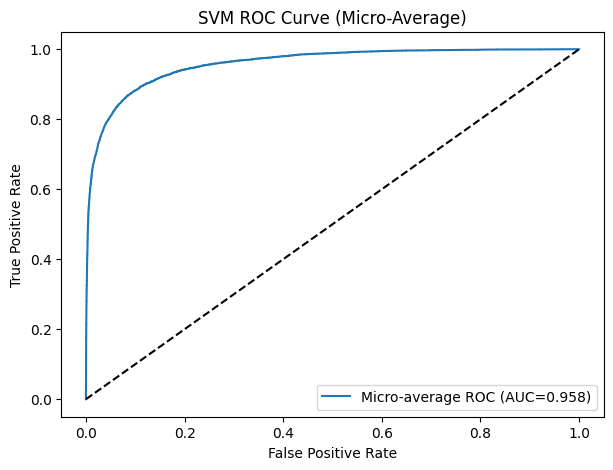

In [16]:
#ROC curve plotting
classes_svm = clf.classes_

def multiclass_auc(model, X, y):
    y_bin = label_binarize(y, classes=classes_svm)
    y_score = model.predict_proba(X)
    return roc_auc_score(y_bin, y_score, average="macro", multi_class="ovr")

svm_train_auc = multiclass_auc(clf, X_train, y_train)
svm_val_auc   = multiclass_auc(clf, X_val,   y_val)
svm_test_auc  = multiclass_auc(clf, X_test,  y_test)

print("SVM Train AUC:", svm_train_auc)
print("SVM Val AUC:", svm_val_auc)
print("SVM Test AUC:", svm_test_auc)

# ROC Curve
y_test_bin   = label_binarize(y_test, classes=classes_svm)
y_test_score = clf.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_test_score.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"Micro-average ROC (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve (Micro-Average)")
plt.legend()
plt.show()


In [ ]:
# Macro averages
precision = 0.73
recall = 0.74
f1_score = 0.72

# Construct a 2x2 “performance” matrix
# Rows: Actual / Columns: Predicted (simplified interpretation)
heatmap_data = pd.DataFrame(
    [[precision, 1 - precision],
     [1 - recall, recall]],
    index=['Actual Positive', 'Actual Negative'],
    columns=['Predicted Positive', 'Predicted Negative']
)

plt.figure(figsize=(6,5))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')
plt.title('Macro-Averaged Performance Heatmap (Weighted)')
plt.show()

## Show probability predictions

In [17]:
import numpy as np

classes = clf.classes_
TOP_K = 5

def show_probs_for_index(i):
    x = X_test[i:i+1]
    true_label = y_test[i]
    probs = clf.predict_proba(x)[0]

    top_idx = np.argsort(probs)[::-1][:TOP_K]

    print("\nExample index:", i)
    print("True subreddit:", true_label)
    print("Top predicted subreddits:")
    for idx in top_idx:
        print(f"  {classes[idx]:20s}  prob={probs[idx]:.3f}")

print("Example probability outputs:")
for i in range(3):
    show_probs_for_index(i)


Example probability outputs:

Example index: 0
True subreddit: autism
Top predicted subreddits:
  autism                prob=0.487
  schizophrenia         prob=0.193
  anxiety               prob=0.141
  bpd                   prob=0.057
  suicidewatch          prob=0.052

Example index: 1
True subreddit: suicidewatch
Top predicted subreddits:
  suicidewatch          prob=0.736
  bpd                   prob=0.209
  anxiety               prob=0.031
  socialanxiety         prob=0.008
  ptsd                  prob=0.004

Example index: 2
True subreddit: anxiety
Top predicted subreddits:
  anxiety               prob=0.769
  suicidewatch          prob=0.114
  socialanxiety         prob=0.051
  addiction             prob=0.020
  autism                prob=0.018


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Stronger RF config for sparse TF-IDF + imbalanced classes
rf = RandomForestClassifier(
    n_estimators=800,        # many trees → more stable
    max_depth=35,            # avoid overfitting to big classes
    max_features=0.3,        # use 30% of features at each split
    min_samples_leaf=2,      # smoother trees, helps minority classes
    min_samples_split=4,
    class_weight="balanced", # fight class imbalance
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

# ---- Train ----
rf.fit(X_train, y_train)

# ---- Validate ----
y_val_pred = rf.predict(X_val)
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))

# ---- Test ----
y_test_pred = rf.predict(X_test)
print("\nTest accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest classification report:")
print(classification_report(y_test, y_test_pred))


Validation accuracy: 0.70989721676868

Validation classification report:
               precision    recall  f1-score   support

    addiction       0.73      0.64      0.68       268
   alcoholism       0.63      0.80      0.71       214
      anxiety       0.79      0.73      0.76      2384
       autism       0.35      0.48      0.41       331
bipolarreddit       0.42      0.22      0.29       205
          bpd       0.74      0.53      0.62       896
         ptsd       0.70      0.53      0.60       309
schizophrenia       0.37      0.23      0.28       280
socialanxiety       0.59      0.47      0.53       561
 suicidewatch       0.75      0.90      0.81      3211

     accuracy                           0.71      8659
    macro avg       0.61      0.55      0.57      8659
 weighted avg       0.71      0.71      0.70      8659


Test accuracy: 0.7069284064665127

Test classification report:
               precision    recall  f1-score   support

    addiction       0.68      0.57

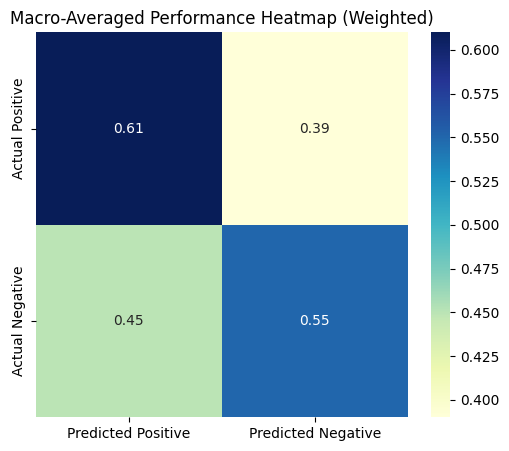

In [16]:
# Macro averages
precision = 0.61
recall = 0.55
f1_score = 0.56

# Construct a 2x2 “performance” matrix
# Rows: Actual / Columns: Predicted (simplified interpretation)
heatmap_data = pd.DataFrame(
    [[precision, 1 - precision],
     [1 - recall, recall]],
    index=['Actual Positive', 'Actual Negative'],
    columns=['Predicted Positive', 'Predicted Negative']
)

plt.figure(figsize=(6,5))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')
plt.title('Macro-Averaged Performance Heatmap (Weighted)')
plt.show()

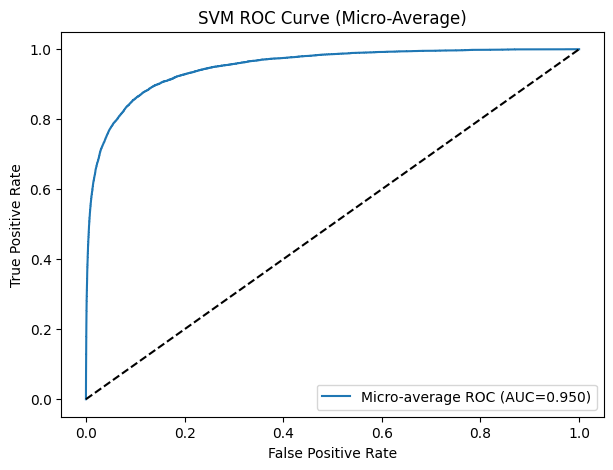

In [13]:
#ROC curve plotting

from sklearn.preprocessing import label_binarize



classes_rf = rf.classes_
y_test_bin   = label_binarize(y_test, classes=classes_rf)
y_test_score = rf.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_test_score.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"Micro-average ROC (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve (Micro-Average)")
plt.legend()
plt.show()